# Hammer Clusters Figure

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
sys.path.append("..")
from curvature import *
from mergetree import *
from covertree import *
from matching import *
from matching_plots import *
from ete3 import Tree, TreeStyle, Tree, ImgFace, TextFace, add_face_to_node
import subprocess
import os

In [2]:
sigma = 20
n_hammers = 20
D = np.zeros((n_hammers, n_hammers))
DW = np.zeros_like(D)
DDTW = np.zeros_like(D)
for i in range(n_hammers):
    print(".", end="")
    X1 = get_contour_curve("../mpeg7/hammer-{}.png".format(i+1))
    curv1 = get_curv_2d(X1, sigma=sigma, loop=True)
    MT1 = MergeTree()
    MT1.init_from_timeseries(curv1, circular=True)
    for j in range(n_hammers):
        X2 = get_contour_curve("../mpeg7/hammer-{}.png".format(j+1))
        curv2 = get_curv_2d(X2, sigma=sigma, loop=True)
        MT2 = MergeTree()
        MT2.init_from_timeseries(curv2, circular=True)
        D[i, j], _, _, _ = circular_dope_match(curv1, curv2)
        DW[i, j] = wasserstein(MT1.PD, MT2.PD)
        #DDTW[i, j] = dtw_cyclic(get_csm(curv1, curv2))

....................

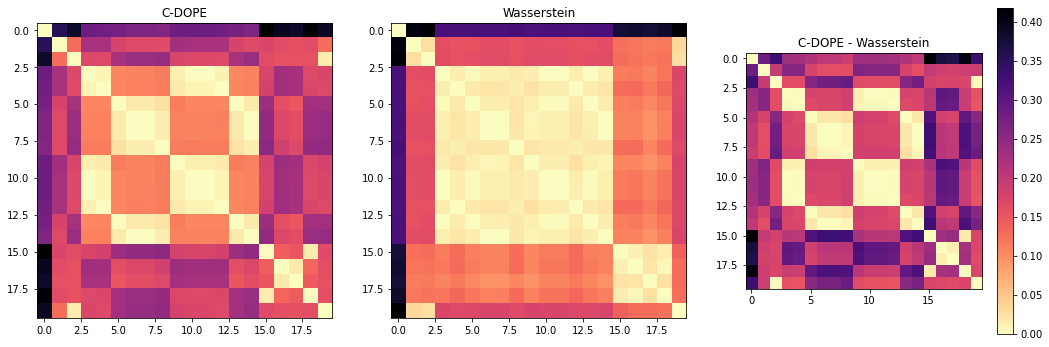

In [3]:
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.imshow(D, cmap='magma_r')
plt.title("C-DOPE")
plt.subplot(132)
plt.imshow(DW, cmap='magma_r')
plt.title("Wasserstein")
plt.subplot(133)
plt.imshow(D-DW, cmap='magma_r')
plt.title("C-DOPE - Wasserstein")
plt.colorbar()

.............

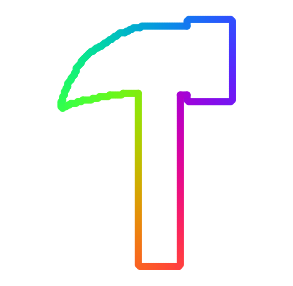

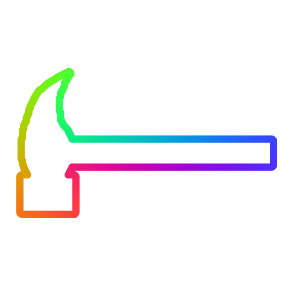

In [4]:
def sinebow(h):
    # https://twitter.com/jon_barron/status/1388233935641976833
    f = lambda x : np.sin(np.pi * x)**2
    return np.stack([f(3/6-h), f(5/6-h), f(7/6-h)], -1)

def plot_tree(t, filename):
    ts = TreeStyle()
    ts.show_leaf_name = False
    ts.show_branch_length = False
    #ts.mode = "c"
    ts.scale = 200
    plt.figure(figsize=(5, 5))
    def pictureLayout(node):
        #http://etetoolkit.org/docs/latest/tutorial/tutorial_drawing.html
        if not type(node.name) == int:
            return
        X = get_contour_curve("../mpeg7/hammer-{}.png".format(node.name))
        plt.clf()
        plt.scatter(X[:, 0], X[:, 1], c=sinebow(np.linspace(0, 1, X.shape[0])))
        plt.axis("equal")
        plt.axis('off')
        imname = "Hammer%s.png"%node.name
        plt.savefig(imname, bbox_inches = 'tight')
        #convert Hammer1.png -background none -transparent white -flatten out.png
        #subprocess.call(["convert", imname, "-background", "none", "-transparent", "white", "-flatten", imname])
        subprocess.call(["mogrify", "-resize", "100x100", imname])
        subprocess.call(["mogrify", "-trim", imname])

        F = ImgFace(imname)
        add_face_to_node(F, node, column=0, position="branch-right")

        F = TextFace(node.name, tight_text = True)
        add_face_to_node(F, node, column=0, position="branch-top")

    def textLayout(node):
        #http://etetoolkit.org/docs/latest/tutorial/tutorial_drawing.html
        if not type(node.name) == int:
            return
        F = TextFace(node.name)
        add_face_to_node(F, node, column=0, position="branch-right")

    ts.layout_fn = pictureLayout
    ts.rotation = 90
    t.render(filename, tree_style = ts, w=800)

    
TDOPE = CoverTree()
seedidx = np.argmin(np.sum(D, 1))
TDOPE.construct(D, seedidx)
t = TDOPE.getETETree(names = [i+1 for i in range(20)])
plot_tree(t, "HammerClustersDOPE.svg")

TWass = CoverTree()
seedidx = np.argmin(np.sum(DW, 1))
TWass.construct(DW, seedidx)
t = TWass.getETETree(names = [i+1 for i in range(20)])
plot_tree(t, "HammerClustersWass.svg")


for i in range(n_hammers):
    os.remove("Hammer%s.png"%(i+1))